# Get Current Forecast

read out the forecast for different companies for today. Source of forecast data is [https://kursprognose.com](https://kursprognose.com)

In [1]:
from finance_monitor.forecastgrapper import ForecastGrapper
fcg = ForecastGrapper()

Forecast data saved to 20250402_nvidia_forecast.csv
Forecast data saved to 20250402_nvidia_forecast.csv
Current stock price of nvidia is 110.42 USD / 101.98 EUR


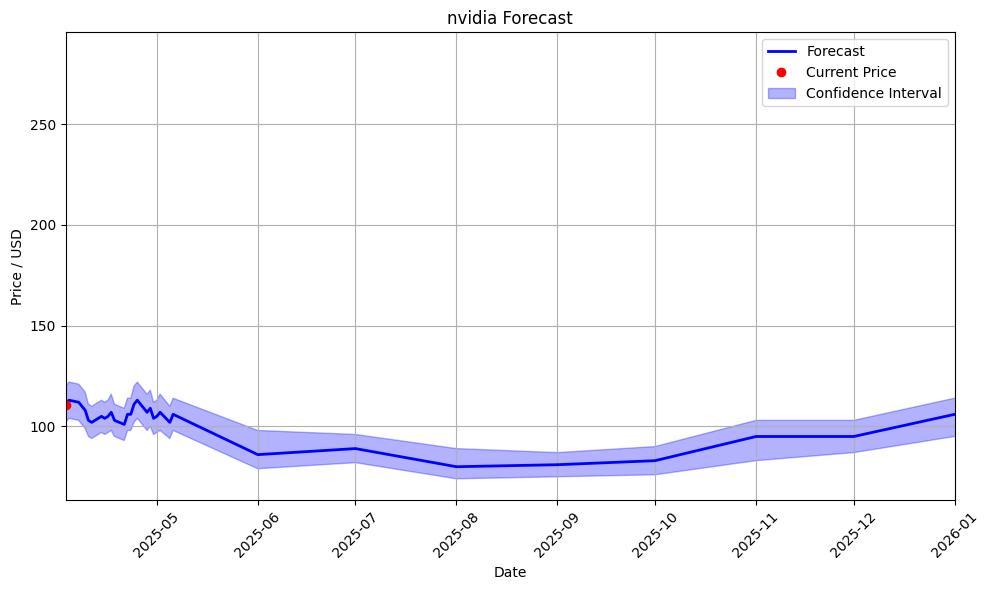

In [2]:
fcg.grap_forecast()
fcg.save_forecast()
fcg.plot_forecast(31)

Forecast data saved to 20250402_rhm-aktie_forecast.csv
Forecast data saved to 20250402_rhm-aktie_forecast.csv
Current stock price of rhm-aktie is 1410.0 USD / 1302.28 EUR


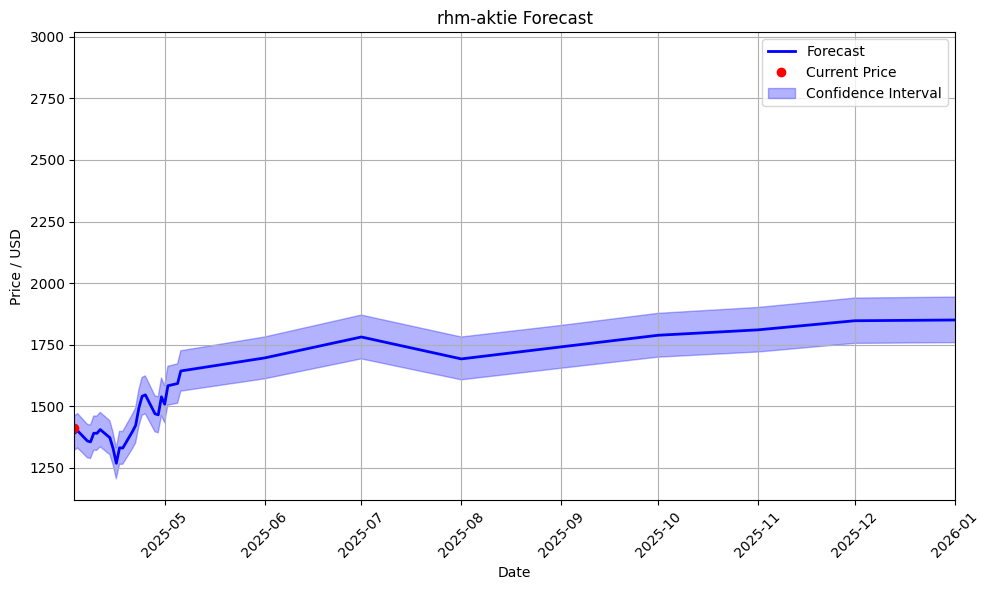

In [3]:
fcg.set_company("rhm-aktie")
fcg.grap_forecast()
fcg.save_forecast()
fcg.plot_forecast(31)

Forecast data saved to 20250402_tesla_forecast.csv
Forecast data saved to 20250402_tesla_forecast.csv
Current stock price of tesla is 282.76 USD / 261.16 EUR


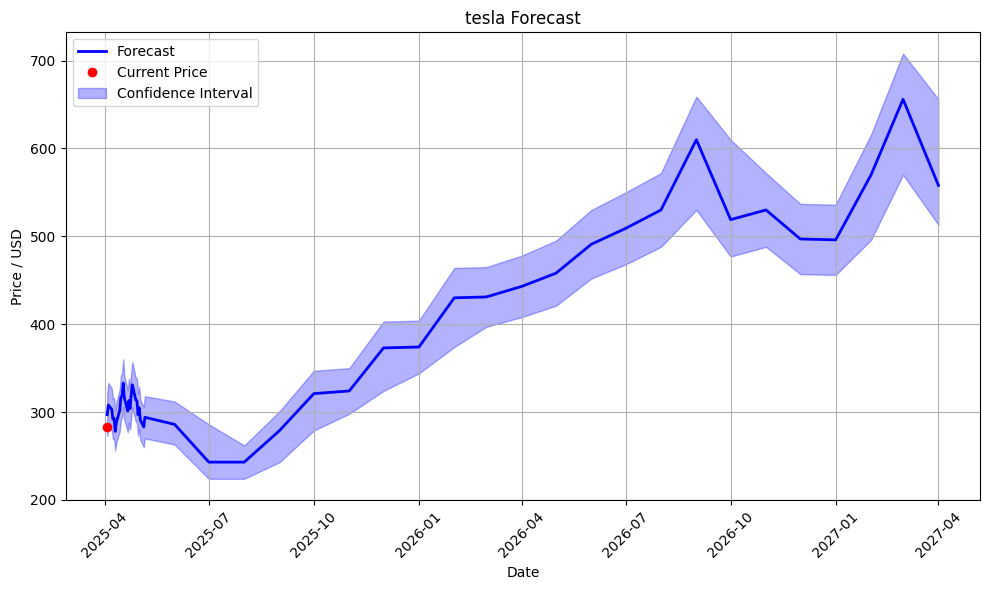

In [4]:
fcg.set_company("tesla")
fcg.grap_forecast()
fcg.save_forecast()
fcg.plot_forecast()

Forecast data saved to 20250402_netflix_forecast.csv
Forecast data saved to 20250402_netflix_forecast.csv
Current stock price of netflix is 935.52 USD / 864.05 EUR


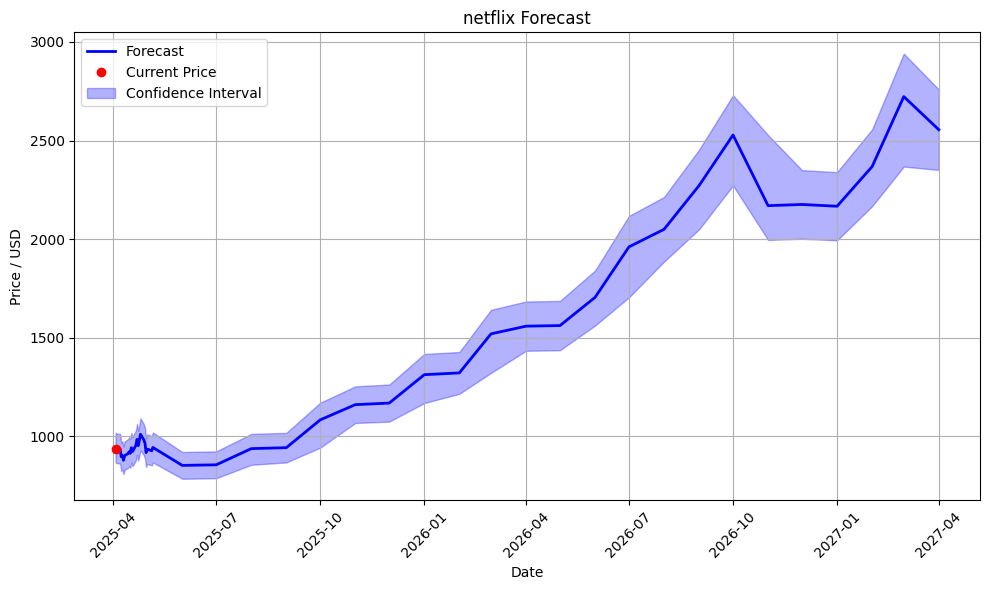

In [5]:
fcg.set_company("netflix")
fcg.grap_forecast()
fcg.save_forecast()
fcg.plot_forecast()

Forecast data saved to 20250402_wmt-stock_forecast.csv
Forecast data saved to 20250402_wmt-stock_forecast.csv
Current stock price of wmt-stock is 89.76 USD / 82.9 EUR


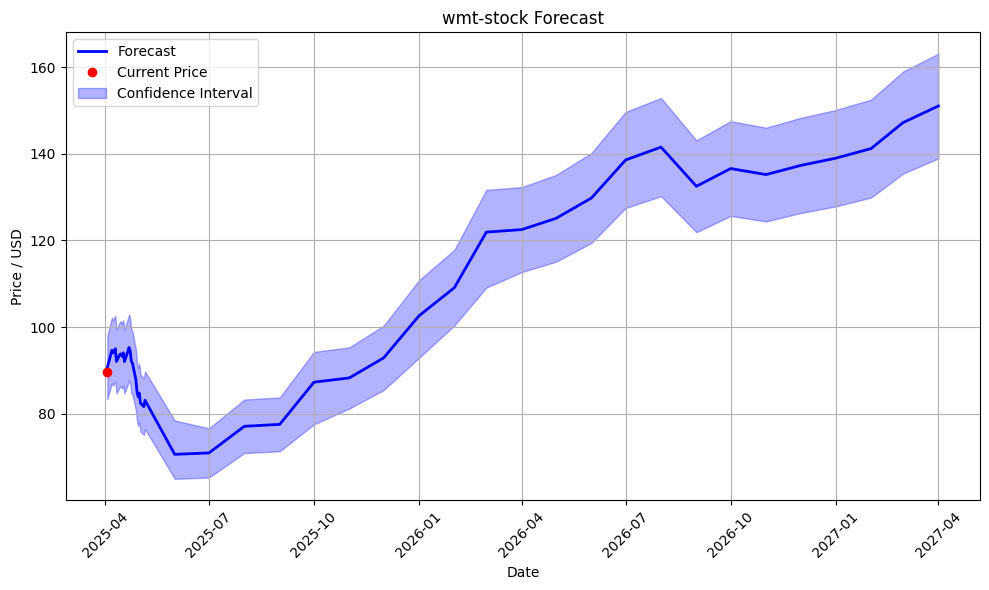

In [6]:
fcg.set_company("wmt-stock")
fcg.grap_forecast()
fcg.save_forecast()
fcg.plot_forecast()

Forecast data saved to 20250402_xpeng_forecast.csv
Forecast data saved to 20250402_xpeng_forecast.csv
Current stock price of xpeng is 21.12 USD / 19.51 EUR


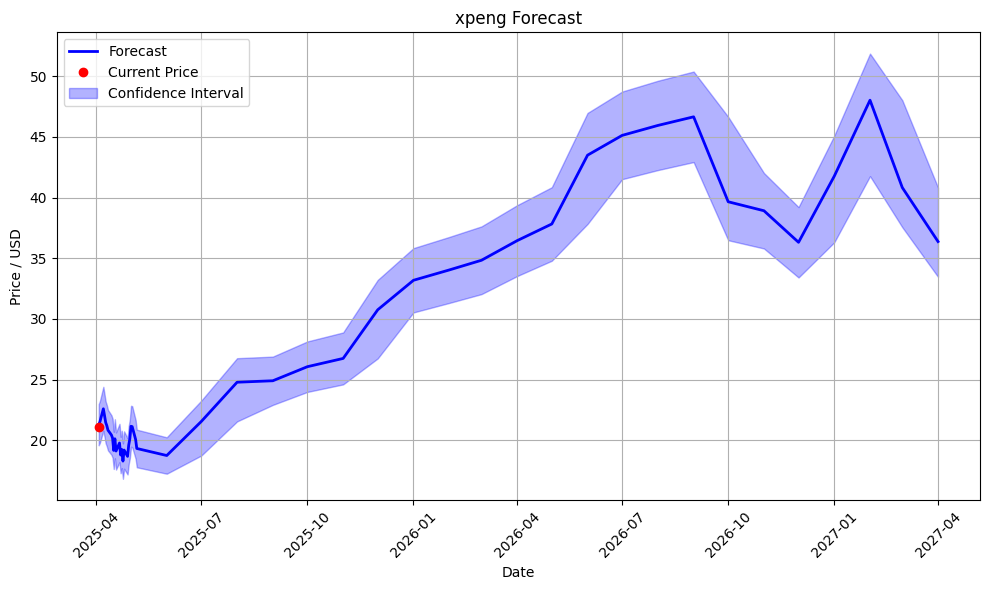

In [7]:
fcg.set_company("xpeng")
fcg.grap_forecast()
fcg.save_forecast()
fcg.plot_forecast()

Forecast data saved to 20250402_mo-stock_forecast.csv
Forecast data saved to 20250402_mo-stock_forecast.csv
Current stock price of mo-stock is 57.12 USD / 52.77 EUR


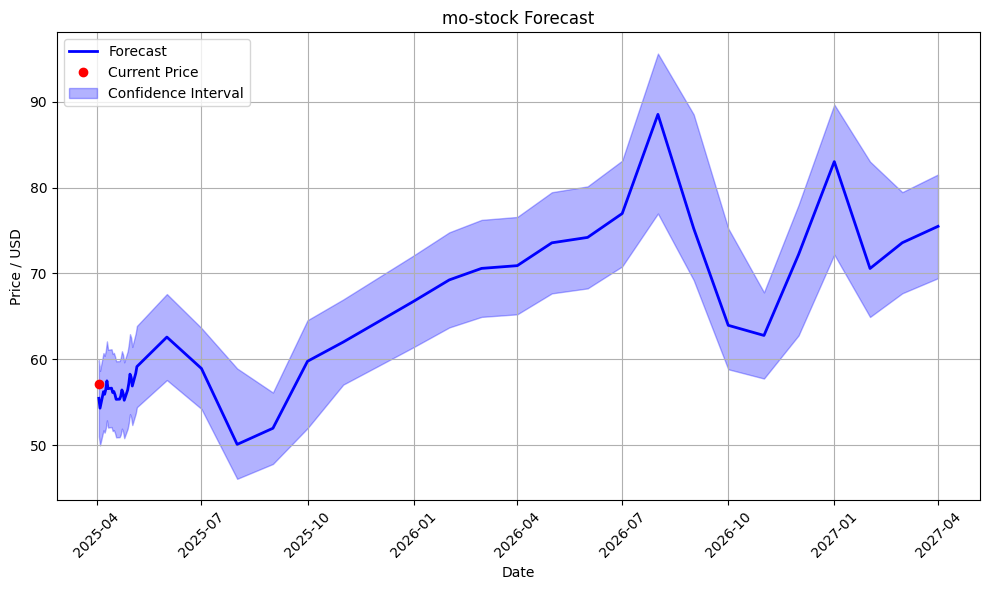

In [8]:
fcg.set_company("mo-stock")
fcg.grap_forecast()
fcg.save_forecast()
fcg.plot_forecast()